<h1><center>Boston Marathon</h1>

You now have a pretty varied suite of clustering and clustering evaluation methods; we'd be remiss if we didn't give you the opportunity to try them out on some real data. So here we go!

There is a lot of information on runners and their performance for the Boston Marathon. Pick a year (post-2012 has more info) and do some clustering.

Specifically, use the tools at hand to determine which clustering solution, including number of clusters and algorithm used, is best for the marathon data. Once you have a solution you like, write a data story, including visualizations, where you teach the reader something about the Boston Marathon based on your clusters. Write up your report, including your process from start to finish, in a Jupyter notebook and submit it below.

## Data Preparation

In [31]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from regressors import stats,plots
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn import metrics
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Load 2014 Boston marathon data:

In [2]:
df0 = pd.read_csv('../data/marathon.csv',low_memory=False)
df0.head(1)

,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,35k,overall,pace,state,30k,5k,half,20k,country,city,40k
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,NaN,71.40,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43


Select time columns and drop missing data:

In [6]:
data = df0[['5k','10k','20k','30k','40k','official']]
data = data.apply(pd.to_numeric,errors='coerce')
data = data.dropna()
data.head(5)

,5k,10k,20k,30k,40k,official
0,8.02,17.37,37.65,59.18,80.43,85.25
1,16.22,32.58,65.83,99.33,132.10,138.95
2,7.75,16.62,36.10,56.45,76.10,80.60
3,16.20,32.57,65.83,99.33,132.95,140.58
4,8.02,17.12,36.58,57.03,76.72,81.23


Take a two part approach - generate some clusters and check Adjusted Rand scores but also look at Silhoutte scores to compare algorithms.

### Generate clusters

Check histogram of final times to estimate clusters.

(array([1.900e+01, 2.300e+01, 2.000e+00, 4.000e+01, 1.890e+02, 9.370e+02,
        2.497e+03, 3.511e+03, 4.633e+03, 4.367e+03, 3.565e+03, 2.698e+03,
        2.196e+03, 1.950e+03, 1.412e+03, 1.148e+03, 9.260e+02, 6.520e+02,
        4.120e+02, 3.260e+02, 1.800e+02, 9.700e+01, 4.800e+01, 1.600e+01,
        2.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00]),
 array([ 80.6  ,  95.876, 111.152, 126.428, 141.704, 156.98 , 172.256,
        187.532, 202.808, 218.084, 233.36 , 248.636, 263.912, 279.188,
        294.464, 309.74 , 325.016, 340.292, 355.568, 370.844, 386.12 ,
        401.396, 416.672, 431.948, 447.224, 462.5  , 477.776, 493.052,
        508.328, 523.604, 538.88 ]),
 <a list of 30 Patch objects>)

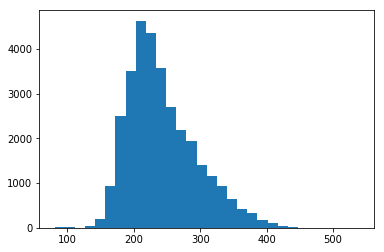

In [4]:
plt.hist(data.official,bins=30)

Divide into 30 minute interval bins:

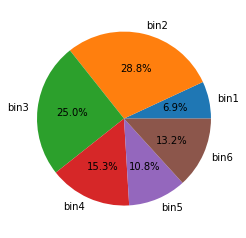

In [7]:
data['bin1'] = 0
data['bin2'] = 0
data['bin3'] = 0
data['bin4'] = 0
data['bin5'] = 0
data['bin6'] = 0
data.loc[data.official < 180,'bin1'] = 1
data.loc[data.official.between(180,219.99,inclusive=True),'bin2'] = 1
data.loc[data.official.between(210,239.99,inclusive=True),'bin3'] = 1
data.loc[data.official.between(240,269.99,inclusive=True),'bin4'] = 1
data.loc[data.official.between(270,299.99,inclusive=True),'bin5'] = 1
data.loc[data.official >= 300,'bin6'] = 1

plt.pie(data.iloc[:,-6:].sum().values, labels=data.iloc[:,-6:].columns.values, autopct='%1.1f%%')
plt.show()

Although bins 2 and 3 are larger than the others, there are still over 10% of times in all other bins except bin 1 so targeting 6 clusters seems appropriate.

### Normalize data

In [8]:
norm_X = normalize(data[['5k','10k','20k','30k','40k','official']])
tgt = data.bin1 + 2*data.bin2 + 3*data.bin3 + 4*data.bin4 + 5*data.bin5 + 6*data.bin6

### Apply PCA (use first two components):

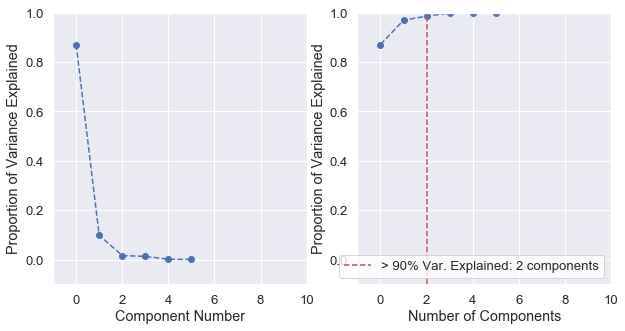

In [9]:
X_pca0 = PCA(6).fit(norm_X)
plots.plot_scree(X_pca0)
X_pca = PCA(2).fit_transform(norm_X)

Plotting the two component PCA against the assigned bins:

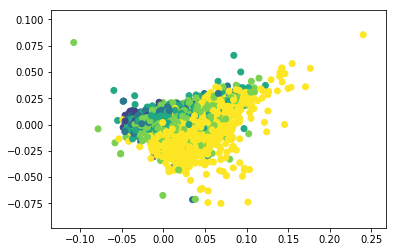

In [42]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=tgt)
plt.show()

# K-Means

### k = 4

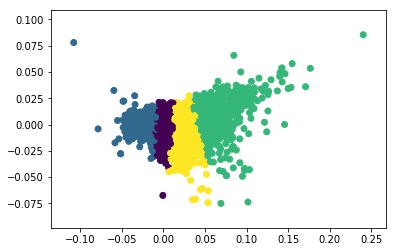

Comparing the assigned categories to the ones in the data:
col_0     1     2     3     4     5     6
row_0                                    
0       452  2194  2503  2539  2711  1510
1      1925  4353  2198  1267  2114   232
2         1    41   116   209   334   557
3        36   374   827  1327  1703  2326
ARI:  0.061624482535830624
Silhoutte score:  0.40333839846074665


In [99]:
from sklearn.cluster import KMeans
y_pred = KMeans(n_clusters=4, random_state=1).fit_predict(norm_X)

# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y_pred,tgt))

print('ARI: ',metrics.adjusted_rand_score(y_pred,tgt))
print('Silhoutte score: ', metrics.silhouette_score(norm_X, y_pred, metric='euclidean'))

### k = 5

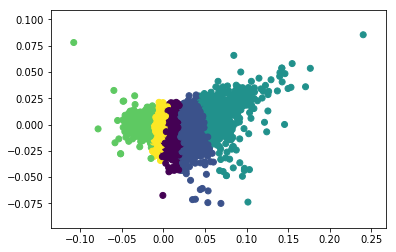

Comparing the assigned categories to the ones in the data:
col_0     1     2     3     4     5     6
row_0                                    
0       109   754  1282  1735  1825  1924
1        15   163   387   672  1037  1491
2         0    21    68   119   184   351
3      1678  3411  1567   845  1550   148
4       612  2613  2340  1971  2266   711
ARI:  0.05751220850229975
Silhoutte score:  0.3626768944050171


In [91]:
y_pred = KMeans(n_clusters=5, random_state=1).fit_predict(norm_X)

# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y_pred,tgt))

print('ARI: ',metrics.adjusted_rand_score(y_pred,tgt))
print('Silhoutte score: ', metrics.silhouette_score(norm_X, y_pred, metric='euclidean'))

### k = 6

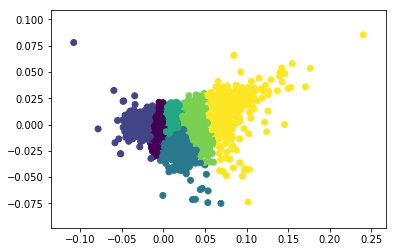

Comparing the assigned categories to the ones in the data:
col_0     1     2     3     4     5     6
row_0                                    
0       612  2568  2284  1909  2235   775
1      1657  3322  1511   807  1505   131
2        19    21   112   340   537  1808
3       113   894  1340  1622  1583   706
4        13   148   354   590   876   940
5         0     9    43    74   126   265
ARI:  0.06247726239385184
Silhoutte score:  0.3582342227811949


In [92]:
y_pred = KMeans(n_clusters=6, random_state=1).fit_predict(norm_X)

# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y_pred,tgt))

print('ARI: ',metrics.adjusted_rand_score(y_pred,tgt))
print('Silhoutte score: ', metrics.silhouette_score(norm_X, y_pred, metric='euclidean'))

None of the K-Means results using k=4-6 appear to fit the original six clusters well. Clusters tended to vertically aligned while the original clusters were closer to horizontal. Adjusted Rand scores are around 0.06 for these K-Means results. Silhoutte scores are around 0.36, suggesting that K-Means does create reasonably distinct clusters.

# Mean-Shift

Number of estimated clusters: 13


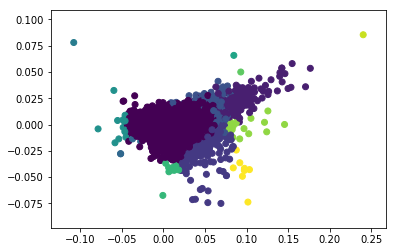

Comparing the assigned categories to the ones in the data:
col_0     1     2     3     4     5     6
row_0                                    
0      2412  6948  5583  5249  6718  4227
1         0     1     7    23    35    90
2         0     0     5     8    27   200
3         1     9    46    55    73    69
4         0     0     1     1     2     0
5         0     0     0     0     1     0
6         1     4     1     3     3     3
7         0     0     0     1     0     0
8         0     0     1     0     2     7
9         0     0     0     1     0     0
10        0     0     0     1     1    20
11        0     0     0     0     0     1
12        0     0     0     0     0     8
ARI:  0.001953884129924969
Silhoutte score:  0.41710884908930007


In [93]:
from sklearn.cluster import MeanShift, estimate_bandwidth

bandwidth = estimate_bandwidth(norm_X, quantile=0.6, n_samples=5000)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(norm_X)

labels = ms.labels_
cluster_centers = ms.cluster_centers_
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(labels,tgt))

print('ARI: ',metrics.adjusted_rand_score(labels,tgt))
print('Silhoutte score: ', metrics.silhouette_score(norm_X, labels, metric='euclidean'))

In contrast to K-Means, the shape of the clusters appears closer to the original but the clusters are much more imbalanced with almost all times placed in the first cluster. The Adjusted Rand score drops to almost 0. The Silhoutte score is about 0.42, however, suggesting that Mean-Shift is generating reasonable clusters and that the originally defined bins may be at fault.

# Spectral Clustering

### Three cluster

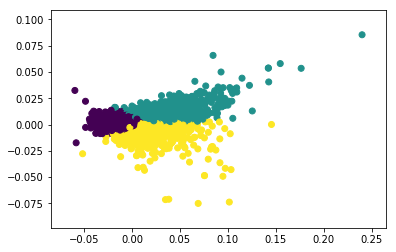

Comparing the assigned categories to the ones in the data:
col_0     1     2     3    4     5   6
row_0                                 
0      2240  5688  1114  132  1655   8
1        77   639   600  276   386  26
2        90   355   730  474   433  77
ARI:  0.13428815865412094
Silhoutte score:  0.4391640344753969


In [101]:
from sklearn.cluster import SpectralClustering

sample_size = 15000
sc = SpectralClustering(n_clusters=3)
predict=sc.fit_predict(X_pca[:sample_size])

plt.scatter(X_pca[:sample_size, 0], X_pca[:sample_size, 1], c=predict)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(predict,tgt[:sample_size]))

print('ARI: ',metrics.adjusted_rand_score(predict,tgt[:sample_size]))
print('Silhoutte score: ', metrics.silhouette_score(norm_X[:sample_size], predict, metric='euclidean'))

### Four cluster

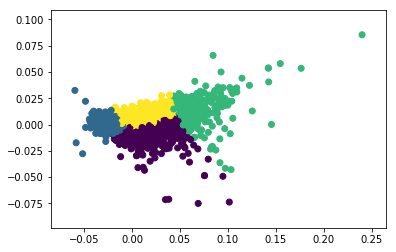

Comparing the assigned categories to the ones in the data:
col_0     1     2     3    4     5   6
row_0                                 
0        89   318   654  456   409  60
1      1726  3484   382   47   807   7
2         1    23    69   97    70  36
3       591  2857  1339  282  1188   8
ARI:  0.09439619688853694
Silhoutte score:  0.34332729902393877


In [102]:
sample_size = 15000
sc = SpectralClustering(n_clusters=4)
predict=sc.fit_predict(X_pca[:sample_size])

plt.scatter(X_pca[:sample_size, 0], X_pca[:sample_size, 1], c=predict)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(predict,tgt[:sample_size]))

print('ARI: ',metrics.adjusted_rand_score(predict,tgt[:sample_size]))
print('Silhoutte score: ', metrics.silhouette_score(norm_X[:sample_size], predict, metric='euclidean'))

Spectral clustering performed better. Using a sub-sample or 15000 points, targeting three and four clusters resulted in Adjusted Rand scores around 0.13 and 0.09, respectively. The Silhoutte score for three clusters was around 0.44 but for four clusters, dropped down to 0.34, suggesting that fewer clusters might be better.

# Affinity Propagation

In [97]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

sample_size = 5000
af = AffinityPropagation().fit(norm_X[:sample_size])

# Pull the number of clusters and cluster assignments for each data point.
cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
labels = af.labels_

print('Estimated number of clusters: {}'.format(n_clusters_))

Estimated number of clusters: 119


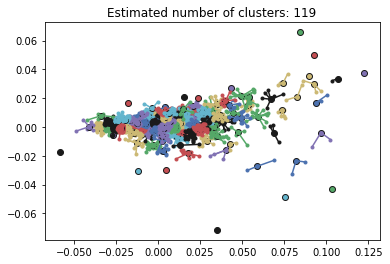

In [66]:
from itertools import cycle

plt.figure(1)
plt.clf()

# Cycle through each cluster and graph them with a center point for the
# exemplar and lines from the exemplar to each data point in the cluster.
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X_pca[cluster_centers_indices[k]]
    plt.plot(X_pca[:sample_size][class_members, 0], X_pca[:sample_size][class_members, 1], col + '.')
    plt.plot(cluster_center[0],
             cluster_center[1],
             'o',
             markerfacecolor=col,
             markeredgecolor='k')
    for x in X_pca[:sample_size][class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: {}'.format(n_clusters_))
plt.show()

In [98]:
print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(labels,tgt[:sample_size]))

print('ARI: ',metrics.adjusted_rand_score(labels,tgt[:sample_size]))
print('Silhoutte score: ', metrics.silhouette_score(norm_X[:sample_size], labels, metric='euclidean'))

Comparing the assigned categories to the ones in the data:
col_0    1   2  3  4   5  6
row_0                      
0       11   0  1  1   1  0
1       23   0  1  0   0  0
2        5   1  3  0   2  0
3        4  21  2  1   3  0
4        1   0  0  0   0  0
5        8   2  0  2   0  0
6        8  12  2  0   0  0
7        0   1  1  1   0  0
8        1   4  3  0   1  0
9      135  64  1  0   0  0
10       0   1  0  0   0  0
11       5  20  1  2   1  0
12       0   0  1  0   0  0
13       0   0  1  0   0  0
14     125  33  0  0   4  0
15      19  43  1  1   3  0
16       3   1  1  3   0  0
17     139  82  0  0   2  0
18       0   0  0  1   0  0
19       0   0  3  0   1  0
20      36  44  2  0   3  0
21      62  64  0  0   1  0
22      56  44  1  0   1  0
23       0   0  0  1   0  0
24      18  40  1  0   2  0
25       1  13  1  0   3  0
26       0   7  3  0   2  0
27       0   0  0  0   1  0
28      17  23  1  0   0  0
29       3   7  2  0   8  0
...    ...  .. .. ..  .. ..
89       0   0  2

Using a 5000 point sub-sample, affinity propagation still estimated 119 clusters, much more granular than is probably useful. The Adjusted Rand score was only 0.013 and Silhoutte score was 0.19.

# Conclusions

Four unsupervised clustering methods tested were tested: K-Means, Mean-Shift, Spectral Clustering and Affinity Propagation.

### Adjusted Rand score
 - Spectral Clustering most closely matched the original six bin grouping with an Adjusted Rand score around 0.13.
 - Mean-Shift did not perform well, placing almost all points in a single cluster, resulting in an Adjusted Rand score slightly above zero.
 - K-Means had Adjusted Rand score around 0.06 but the shape of clusters were quite different than expected.
 - Affinity Propagation resulted in a high number of estimated clusters and a low Adjusted Rand score of 0.013.

### Silhoutte score
 - Mean-Shift had one of the highest Silhoutte scores at 0.42.
 - Spectral Clustering had the highest Silhoutte score of 0.44 using a three cluster target but only had a Silhoutte score of 0.34 for a four cluster target. This underscores the importance of choosing number of clusters.
 - K-Means had slightly lower Silhoutte scores around 0.35.
 - Affinity Propagation had a low Silhoutte score of 0.19.

The Adjusted Rand scores were all relatively low, topping out at 0.13 while apart from Affinity Propagation, Silhoutte scores were above 0.3. This suggests that the initial six bin grouping could have been improved upon.